In [5]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import keras # for building the CNN model
from keras.preprocessing import image # for preprocessing the images
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint #automatically saves the model to a file.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
!pip install keras


In [8]:
folder_path = "/content/drive/MyDrive/datasets"

# Function to recursively process video files in subfolders
def process_videos(folder_path):
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path) and item.endswith(".mp4"):  # Assuming videos are .mp4
            # Process the video file here (e.g., extract frames, etc.)
            print(f"Processing video: {item_path}")
            video = cv2.VideoCapture(item_path)
            # ... (Your video processing logic here) ...

        elif os.path.isdir(item_path):  # If it's a directory, recurse
            process_videos(item_path)

# Call the function to start processing
process_videos(folder_path)

Processing video: /content/drive/MyDrive/datasets/handflap/Copy of flap1.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/flapflap.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/armflap.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/Arm Flapping.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/Evie - autistic stimming.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/flap3.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/flap4.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/Jack - building lego bridge with arm flapping - September 8, 2009.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/flap5.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/flap1.mp4
Processing video: /content/drive/MyDrive/datasets/handflap/flap2.mp4
Processing video: /content/drive/MyDrive/datasets/test/spinnig/Early signs of autism_ stimming____.mp4
Processing video: /content/drive/MyDriv

In [9]:
# Set the paths to your training and testing data
train_directory = '/content/drive/MyDrive/datasets/train'
test_directory = '/content/drive/MyDrive/datasets/test'

In [10]:
# Set the desired image size and number of frames per video
image_size = 150
num_frames = 64

In [11]:
#Function to load and preprocess video data
'''def load_and_preprocess_video(video_path, image_size, num_frames):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (image_size, image_size))
        frames.append(frame)
    cap.release()
    '''

'def load_and_preprocess_video(video_path, image_size, num_frames):\n    frames = []\n    cap = cv2.VideoCapture(video_path)\n    while True:\n        ret, frame = cap.read()\n        if not ret:\n            break\n        frame = cv2.resize(frame, (image_size, image_size))\n        frames.append(frame)\n    cap.release()\n    '

In [12]:
#Function to load and preprocess video data
def load_and_preprocess_video(video_path, image_size, num_frames):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (image_size, image_size))
        frames.append(frame)
    cap.release()
    #insure all videos have the same number of frames
    # Check if frames is not empty and has the expected dimensions before padding
    if frames and len(frames[0].shape) == 3:
        if len(frames) < num_frames:
            frames = np.pad(frames, ((0, num_frames - len(frames)), (0, 0), (0, 0), (0, 0)), 'constant')
        elif len(frames) > num_frames:
            # Truncate if more frames
            frames = frames[:num_frames]
        return np.array(frames) # Dedent this line to match the 'if' block
    else:
        # Handle the case of empty or incorrectly shaped frames
        print(f"Error processing video: {video_path}")
        return np.empty((num_frames, image_size, image_size, 3))  # Return empty array to avoid errors

In [13]:
# Load and preprocess testing data
X_test = []
y_test = []
for category in os.listdir(test_directory):
    category_path = os.path.join(test_directory, category)
    for video_file in os.listdir(category_path):
        video_path = os.path.join(category_path, video_file)
        frames = load_and_preprocess_video(video_path, image_size, num_frames)
        X_test.append(frames)
        y_test.append(os.listdir(test_directory).index(category))

In [14]:
# Load and preprocess training data
X_train = []
y_train = []
for category in os.listdir(train_directory):
    category_path = os.path.join(train_directory, category)
    for video_file in os.listdir(category_path):
        video_path = os.path.join(category_path, video_file)
        frames = load_and_preprocess_video(video_path, image_size, num_frames)
        X_train.append(frames)
        y_train.append(os.listdir(train_directory).index(category))

In [15]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train [[[[[ 77  77  77]
    [ 66  66  66]
    [ 58  58  58]
    ...
    [103 136 133]
    [103 136 133]
    [103 136 133]]

   [[ 65  65  65]
    [ 63  63  63]
    [ 65  65  65]
    ...
    [103 136 133]
    [103 136 133]
    [103 136 133]]

   [[ 55  55  55]
    [ 61  61  61]
    [ 66  66  66]
    ...
    [103 136 133]
    [103 136 133]
    [103 136 133]]

   ...

   [[165 162 140]
    [162 160 138]
    [159 157 135]
    ...
    [ 27  35  32]
    [ 19  27  24]
    [ 12  20  17]]

   [[163 156 135]
    [161 154 133]
    [157 150 129]
    ...
    [ 23  31  28]
    [ 16  24  21]
    [  9  17  14]]

   [[147 140 119]
    [137 130 109]
    [127 120  99]
    ...
    [ 21  29  26]
    [ 14  22  19]
    [  7  15  11]]]


  [[[ 57  57  57]
    [ 62  62  62]
    [ 66  66  66]
    ...
    [103 136 133]
    [103 136 133]
    [103 136 133]]

   [[ 55  55  55]
    [ 60  60  60]
    [ 64  64  64]
    ...
    [103 136 133]
    [103 136 133]
    [103 136 133]]

   [[ 61  61  61]
    [ 60  60  60]
  

In [ ]:
# Define the CNN model architecture
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

#reduce their dimensions while retaining the most important features.
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=(64, 150, 150, 3)))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same')) # Add padding to avoid negative dimensions
model.add(MaxPooling3D((2, 2, 2)))
model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same')) # Add padding to avoid negative dimensions
model.add(MaxPooling3D((2, 2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model immediately after definition
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=2,  # Number of training epochs
    batch_size=5,  # Number of samples processed before updating weights
    validation_data=(X_test, y_test)  # Data for evaluating performance during training
)a

Epoch 1/2
5/5 [==============================] - 93s 18s/step - loss: 4525.6050 - accuracy: 0.3636 - val_loss: 286.8683 - val_accuracy: 0.3333
Epoch 2/2
5/5 [==============================] - 91s 18s/step - loss: 88.5710 - accuracy: 0.3182 - val_loss: 24.0240 - val_accuracy: 0.3333


In [25]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [36]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}%')


1/1 [==============================] - 1s 718ms/step - loss: 24.0240 - accuracy: 0.3333
Test accuracy: 0.33%


In [26]:
# Plot the training and validation accuracy
import matplotlib.pyplot as plt


Epoch 1/2
1/1 [==============================] - ETA: 0s - loss: 7.7338 - accuracy: 0.4706
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.keras
1/1 [==============================] - 70s 70s/step - loss: 7.7338 - accuracy: 0.4706 - val_loss: 4.5464e-05 - val_accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 8.0542 - accuracy: 0.2353
Epoch 2: val_accuracy did not improve from 1.00000
1/1 [==============================] - 68s 68s/step - loss: 8.0542 - accuracy: 0.2353 - val_loss: 5.4591 - val_accuracy: 0.0000e+00


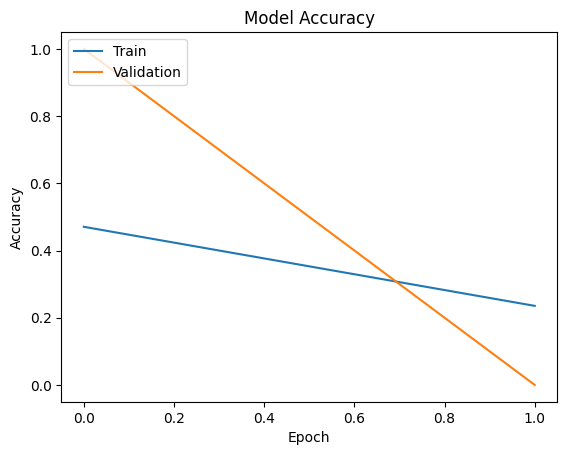

In [38]:
# Assuming 'model' is your compiled Keras model and you have training data X_train, y_train
history = model.fit(X_train, y_train, epochs=2, validation_split=0.2, callbacks=[checkpoint])  # 20% for validation

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()